# Download data (have to run twice for some reason?)


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("balraj98/deepglobe-land-cover-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepglobe-land-cover-classification-dataset


#download loss function

In [ ]:
# 1. Clean up by removing any conflicting file named 'losses'
# The -f flag prevents an error if the file doesn't exist.
!rm -f losses

# 2. Create the 'losses' directory.
# The -p flag prevents an error if the directory already exists.
!mkdir -p losses

# 3. Create the __init__.py file inside the new directory
!touch losses/__init__.py

# --- Download all files directly into the 'losses' directory ---

# List of loss files to download
files = [
    "combo.py",
    "dice.py",
    "focal.py",
    "focal_tversky.py",
    "jaccard.py",
    "lovasz_softmax.py",
    "topk.py",
    "tversky.py",
    "utils.py"

]

# Base URL of the repository
base_url = "https://raw.githubusercontent.com/YilmazKadir/Segmentation_Losses/main/losses/"

# Download each file into the './losses/' directory
for file in files:
    # Use the -P flag to specify the output directory
    !wget -q -P ./losses/ {base_url}{file}

print("\n✅ All loss function files downloaded correctly into the 'losses' folder.")


✅ All loss function files downloaded correctly into the 'losses' folder.


In [ ]:
%%writefile losses/CombinedLoss.py

import torch
import torch.nn as nn

NUM_CLASSES = 7

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, NUM_CLASSES).permute(0, 3, 1, 2).float()

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        logpt = -torch.nn.functional.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * logpt
        return loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(alpha, gamma)

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.focal(preds, targets)

Writing losses/CombinedLoss.py


# Train pipeline



## visualize images

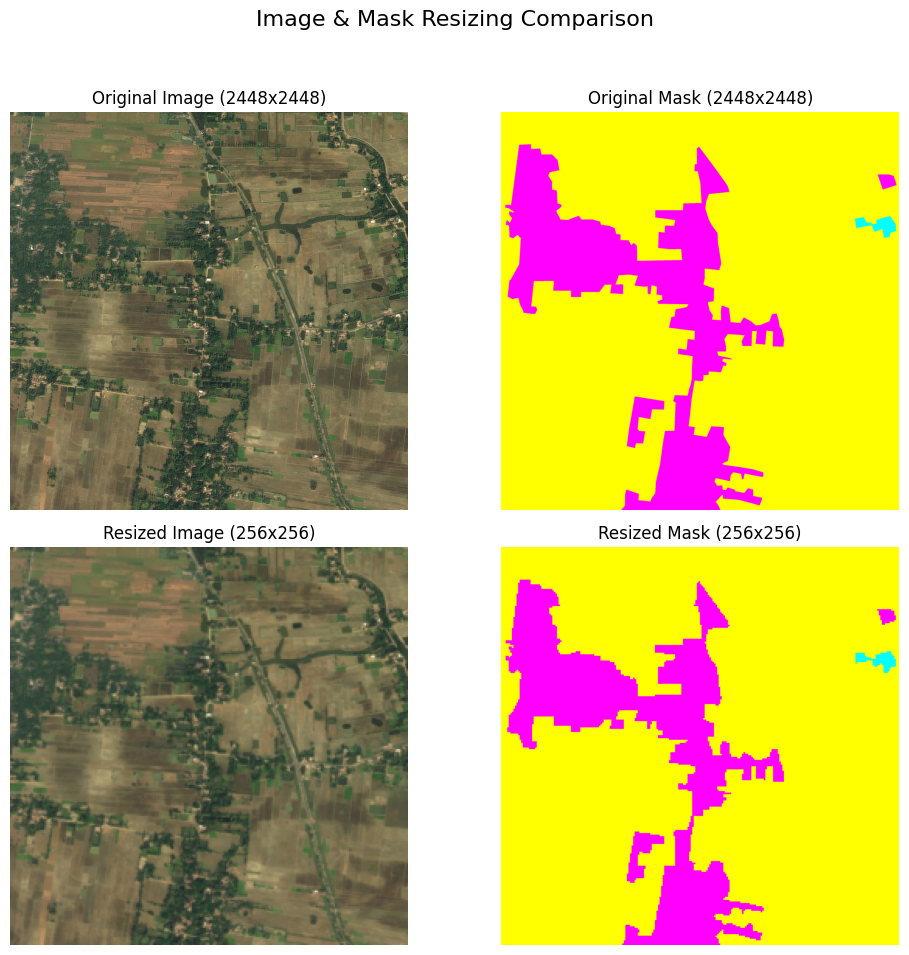

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

# --- Configuration ---
ROOT_DIR = '/kaggle/input/deepglobe-land-cover-classification-dataset'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TARGET_SIZE = 256

# Use a sample image from the dataset
# If this specific file doesn't exist, change it to one that does.
IMG_NAME = '103730_sat.jpg'
MASK_NAME = IMG_NAME.replace('_sat.jpg', '_mask.png')

# Construct full paths
image_path = os.path.join(TRAIN_DIR, IMG_NAME)
mask_path = os.path.join(TRAIN_DIR, MASK_NAME)

# --- Main Logic ---
try:
    # 1. Load original images from disk
    original_image = Image.open(image_path).convert('RGB')
    original_mask = Image.open(mask_path).convert('RGB') # Load as RGB to see colors

    # 2. Define the resizing transforms exactly as in your script
    # For the image (smooth interpolation)
    image_transform = transforms.Resize((TARGET_SIZE, TARGET_SIZE),
                                        interpolation=transforms.InterpolationMode.BILINEAR)

    # For the mask (preserves sharp class boundaries)
    mask_transform = transforms.Resize((TARGET_SIZE, TARGET_SIZE),
                                       interpolation=transforms.InterpolationMode.NEAREST)

    # 3. Apply the transforms in memory
    resized_image = image_transform(original_image)
    resized_mask = mask_transform(original_mask)

    # 4. Display the results using Matplotlib
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Image & Mask Resizing Comparison', fontsize=16)

    # Original Image
    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title(f'Original Image ({original_image.width}x{original_image.height})')
    ax[0, 0].axis('off')

    # Original Mask
    ax[0, 1].imshow(original_mask)
    ax[0, 1].set_title(f'Original Mask ({original_mask.width}x{original_mask.height})')
    ax[0, 1].axis('off')

    # Resized Image
    ax[1, 0].imshow(resized_image)
    ax[1, 0].set_title(f'Resized Image ({resized_image.width}x{resized_image.height})')
    ax[1, 0].axis('off')

    # Resized Mask
    ax[1, 1].imshow(resized_mask)
    ax[1, 1].set_title(f'Resized Mask ({resized_mask.width}x{resized_mask.height})')
    ax[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find the sample file at {image_path}")
    print("Please make sure the dataset path is correct and the file exists.")

## Training pipeline code (written with claude)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Preamble to fix PyTorch 2.x/Dynamo environment issues ---

try:
    import torch._dynamo
    torch._dynamo.disable()
    print("✅ TorchDynamo has been disabled.")
except (AttributeError, ImportError):
    print("⚠️ Could not disable TorchDynamo (may be an older PyTorch version).")

# --- End Preamble ---

from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import alexnet, AlexNet_Weights
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import time
from tqdm import tqdm
import json
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

try:
    from losses.combo import ComboLoss
    from losses.dice import DiceLoss
    from losses.focal import FocalLoss
    from losses.focal_tversky import FocalTverskyLoss
    from losses.jaccard import JaccardLoss
    from losses.lovasz_softmax import LovaszSoftmaxLoss
    from losses.topk import TopKLoss
    from losses.tversky import TverskyLoss
    from losses.CombinedLoss import CombinedLoss
except ImportError:
    print("Warning: Custom loss functions not found, using CrossEntropyLoss as fallback")

class AlexNetSegmentation(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNetSegmentation, self).__init__()

        self.backbone = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        self.features = self.backbone.features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, num_classes, 4, 2, 1),
        )

        self.classifier = nn.Conv2d(num_classes, num_classes, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x

class DeepGlobeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.data_dir = os.path.join(root_dir, split)

        all_files = os.listdir(self.data_dir)
        self.images = sorted([f for f in all_files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img_name = self.images[idx]

      # Correctly replace '_sat.jpg' with '_mask.png'
      mask_name = img_name.replace('_sat.jpg', '_mask.png')

      image_path = os.path.join(self.data_dir, img_name)
      mask_path = os.path.join(self.data_dir, mask_name)

      image = Image.open(image_path).convert('RGB')
      mask = Image.open(mask_path).convert('L')

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          mask = self.target_transform(mask)

      # The target_transform now includes ToTensor, so mask is already a tensor.
      # Squeeze to remove the channel dimension added by ToTensor and cast to long.
      mask = mask.squeeze(0).long()

      return image, mask

class PatchedDeepGlobeDataset(DeepGlobeDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define the official RGB colors for each class
        self.colormap = np.array([
            [0, 0, 0],          # 0=Unknown
            [0, 255, 255],      # 1=Urban
            [255, 255, 0],      # 2=Agriculture
            [255, 0, 255],      # 3=Rangeland
            [0, 255, 0],        # 4=Forest
            [0, 0, 255],        # 5=Water
            [255, 255, 255]     # 6=Barren
        ])

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('_sat.jpg', '_mask.png')
        image_path = os.path.join(self.data_dir, img_name)
        mask_path = os.path.join(self.data_dir, mask_name)

        image = Image.open(image_path).convert('RGB')
        mask_rgb = Image.open(mask_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask_rgb = self.target_transform(mask_rgb)

        mask_rgb_np = np.array(mask_rgb)

        # Binarize the mask at threshold 128 to clean up JPEG artifacts
        binarized_mask_np = (mask_rgb_np > 128).astype(np.uint8) * 255

        # Create an empty array for the final class indices (0-6)
        mask_labels = np.zeros((binarized_mask_np.shape[0], binarized_mask_np.shape[1]), dtype=np.uint8)

        # For each color in the colormap, find where it is in the binarized mask
        # and set the corresponding class index in our label map
        for class_index, color in enumerate(self.colormap):
            matches = np.all(binarized_mask_np == color, axis=-1)
            mask_labels[matches] = class_index

        # Convert the final label map to a tensor
        mask = torch.from_numpy(mask_labels).long()

        return image, mask

class MetricsTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.ious = []
        self.f1_scores = []

    def update(self, loss, accuracy, iou, f1):
        self.losses.append(loss)
        self.accuracies.append(accuracy)
        self.ious.append(iou)
        self.f1_scores.append(f1)

    def get_averages(self):
        return {
            'loss': np.mean(self.losses),
            'accuracy': np.mean(self.accuracies),
            'iou': np.mean(self.ious),
            'f1': np.mean(self.f1_scores)
        }

class TrainingPipeline:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes=7):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_classes = num_classes
        self.train_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}
        self.val_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}


    def calculate_metrics(self, outputs, targets):
        predicted = torch.argmax(outputs, dim=1)

        accuracy = (predicted == targets).float().mean().item()

        # Convert to numpy for sklearn metrics
        pred_np = predicted.cpu().numpy().flatten()
        target_np = targets.cpu().numpy().flatten()

        # print(pred_np)
        # print(target_np)



        # IoU using sklearn (this was correct)
        iou = jaccard_score(target_np, pred_np, average="macro", zero_division=0)

        # F1 score using sklearn (proper multi-class F1)
        from sklearn.metrics import f1_score
        f1 = f1_score(target_np, pred_np, average="macro", zero_division=0)

        # Dice coefficient (macro-averaged across classes)
        dice_scores = []
        for class_idx in range(7):  # assuming 7 classes
            pred_class = (predicted == class_idx).float()
            target_class = (targets == class_idx).float()

            intersection = (pred_class * target_class).sum().item()
            union = pred_class.sum().item() + target_class.sum().item()

            if union == 0:
                dice_scores.append(1.0)  # Perfect score if both pred and target are empty
            else:
                dice_scores.append((2.0 * intersection) / union)

        dice = sum(dice_scores) / len(dice_scores)  # macro average

        return accuracy, iou, f1

    def train(self, num_epochs, model_save_path):
        best_val_iou = 0.0

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 80)

            start_time = time.time()

            train_metrics = self.train_epoch_with_resize()
            val_metrics = self.validate_epoch_with_resize()

            if self.scheduler:
                self.scheduler.step()

            epoch_time = time.time() - start_time

            self.train_history['loss'].append(train_metrics['loss'])
            self.train_history['accuracy'].append(train_metrics['accuracy'])
            self.train_history['iou'].append(train_metrics['iou'])
            self.train_history['f1'].append(train_metrics['f1'])

            self.val_history['loss'].append(val_metrics['loss'])
            self.val_history['accuracy'].append(val_metrics['accuracy'])
            self.val_history['iou'].append(val_metrics['iou'])
            self.val_history['f1'].append(val_metrics['f1'])

            print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, IoU: {train_metrics["iou"]:.4f}, F1: {train_metrics["f1"]:.4f}')
            print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, IoU: {val_metrics["iou"]:.4f}, F1: {val_metrics["f1"]:.4f}')
            print(f'Time: {epoch_time:.2f}s')

            if val_metrics['iou'] > best_val_iou:
                best_val_iou = val_metrics['iou']
                torch.save(self.model.state_dict(), model_save_path)
                print(f'Model saved to {model_save_path}')

    def train_epoch_with_resize(self):
        self.model.train()
        metrics = MetricsTracker()
        pbar = tqdm(self.train_loader, desc='Training')
        for images, targets in pbar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
            loss = self.criterion(outputs, targets_resized)
            loss.backward()
            self.optimizer.step()
            accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
            metrics.update(loss.item(), accuracy, iou, f1)
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def validate_epoch_with_resize(self):
        self.model.eval()
        metrics = MetricsTracker()
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for images, targets in pbar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
                loss = self.criterion(outputs, targets_resized)
                accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
                metrics.update(loss.item(), accuracy, iou, f1)
                pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def plot_metrics(self, save_path):
        """Save individual metric plots as separate files"""
        metrics = ['loss', 'accuracy', 'iou', 'f1']
        titles = ['Loss', 'Accuracy', 'IoU', 'F1 Score']

        for metric, title in zip(metrics, titles):
            plt.figure(figsize=(10, 6))
            plt.plot(self.train_history[metric], label='Train', marker='o')
            plt.plot(self.val_history[metric], label='Validation', marker='s')
            plt.title(f'{title} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(title)
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Save individual metric plot
            metric_path = os.path.join(save_path, f'{metric}_plot.png')
            plt.savefig(metric_path, dpi=300, bbox_inches='tight')
            plt.close()

def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with mean and standard deviation."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def colorize_mask(mask, colormap):
    """Converts a segmentation mask (class indices) to a color image."""
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in enumerate(colormap):
        color_mask[mask == class_idx] = color
    return color_mask

def visualize_predictions(model, dataset, device, config, save_path):
    """Shows predictions and saves individual visualization images."""
    num_samples = config.get('visualize_samples', 0)
    if num_samples == 0:
        return

    print("\nGenerating prediction visualizations...")
    model.eval()

    colormap = [
        (0, 0, 0), (0, 255, 255), (255, 255, 0), (255, 0, 255),
        (0, 255, 0), (0, 0, 255), (255, 255, 255)
    ]

    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)

    # Create visualization directory
    viz_dir = os.path.join(save_path, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_mask = dataset[idx]
            image_for_model = image.unsqueeze(0).to(device)
            output = model(image_for_model)
            pred_mask_resized = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            original_image = denormalize(image.clone(), **config['normalization'])
            original_image = original_image.permute(1, 2, 0).cpu().numpy()
            original_image = np.clip(original_image, 0, 1)

            gt_mask_np = gt_mask.cpu().numpy()
            gt_colored = colorize_mask(gt_mask_np, colormap)
            pred_colored = colorize_mask(pred_mask_resized, colormap)

            # Save individual images
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image)
            axes[0].set_title(f'Original Image #{idx}')
            axes[0].axis('off')

            axes[1].imshow(gt_colored)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            axes[2].imshow(pred_colored)
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.tight_layout()
            viz_path = os.path.join(viz_dir, f'prediction_{i+1}.png')
            plt.savefig(viz_path, dpi=300, bbox_inches='tight')
            plt.close()

def get_loss_function(loss_name):
    loss_functions = {}

    try:
        loss_functions['combo'] = CombinedLoss()
        loss_functions['dice'] = DiceLoss()
        loss_functions['focal'] = FocalLoss()
        loss_functions['focal_tversky'] = FocalTverskyLoss()
        loss_functions['jaccard'] = JaccardLoss()
        loss_functions['lovasz'] = LovaszSoftmaxLoss()
        loss_functions['topk'] = TopKLoss()
        loss_functions['tversky'] = TverskyLoss()

    except NameError:
        pass # Custom losses not found

    return loss_functions.get(loss_name.lower(), nn.CrossEntropyLoss())

def create_transforms_from_config(config):
    train_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.RandomHorizontalFlip(p=config['augmentation']['horizontal_flip']),
        transforms.RandomVerticalFlip(p=config['augmentation']['vertical_flip']),
        transforms.ColorJitter(**config['augmentation']['color_jitter']),
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    # Target transform should only resize, not convert to tensor here
    target_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size']), interpolation=Image.NEAREST),
    ])

    return train_transform, val_transform, target_transform

def create_comparison_plots(results_df, master_experiment_path, focus_hyperparameter):
    """Create comparison bar plots for each metric"""
    metrics = ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'train_iou', 'val_iou', 'train_f1', 'val_f1']

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create bar plot
        bars = plt.bar(range(len(results_df)), results_df[metric], alpha=0.7)

        # Color bars based on focus hyperparameter if specified
        if focus_hyperparameter in results_df.columns:
            unique_values = results_df[focus_hyperparameter].unique()
            colors = sns.color_palette("husl", len(unique_values))
            color_map = dict(zip(unique_values, colors))

            for i, bar in enumerate(bars):
                bar.set_color(color_map[results_df.iloc[i][focus_hyperparameter]])

        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Runs')
        plt.xlabel('Run')
        plt.ylabel(metric.replace("_", " ").title())

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)

        # Add legend for focus hyperparameter
        if focus_hyperparameter in results_df.columns:
            legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[val], alpha=0.7)
                             for val in unique_values]
            plt.legend(legend_elements, unique_values, title=focus_hyperparameter.replace('_', ' ').title())

        # Customize x-axis labels
        labels = [f"Run {i+1}" for i in range(len(results_df))]
        plt.xticks(range(len(results_df)), labels, rotation=45)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(master_experiment_path, f'{metric}_comparison.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()

    print(f"Comparison plots saved to {master_experiment_path}")

def main(config, experiment_path, run_id):
    # Set seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(42)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_transform, val_transform, target_transform = create_transforms_from_config(config)

    # 1. Create two separate dataset instances, one for training and one for validation.
    train_full_dataset = PatchedDeepGlobeDataset(
        root_dir=config['data_root'],
        split=config['train_split'],
        transform=train_transform,  # Use training transforms
        target_transform=target_transform
    )

    val_full_dataset = PatchedDeepGlobeDataset(
        root_dir=config['data_root'],
        split=config['train_split'],
        transform=val_transform,    # Use validation transforms
        target_transform=target_transform
    )

    # 2. Create a deterministic set of shuffled indices for the split.
    num_samples = len(train_full_dataset)
    indices = list(range(num_samples))
    split_point = int(config['train_val_split_ratio'] * num_samples)

    generator = torch.Generator().manual_seed(42)
    shuffled_indices = torch.randperm(num_samples, generator=generator).tolist()

    train_indices = shuffled_indices[:split_point]
    val_indices = shuffled_indices[split_point:]

    # 3. Create Subsets from the correct underlying dataset using the indices.
    train_dataset = torch.utils.data.Subset(train_full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(val_full_dataset, val_indices)

    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], shuffle=False,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )

    print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

    model = AlexNetSegmentation(num_classes=config['num_classes']).to(device)
    criterion = get_loss_function(config['loss_function'])
    optimizer = getattr(optim, config['optimizer']['type'].capitalize())(
        model.parameters(), lr=config['optimizer']['lr'],
        weight_decay=config['optimizer'].get('weight_decay', 0)
    )

    if config['scheduler']['type'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, **config['scheduler']['params'])
    else:
        scheduler = None

    pipeline = TrainingPipeline(
        model=model, train_loader=train_loader, val_loader=val_loader,
        criterion=criterion, optimizer=optimizer, scheduler=scheduler,
        device=device, num_classes=config['num_classes']
    )

    # Define file paths inside the experiment folder
    model_save_path = os.path.join(experiment_path, 'best_model.pth')

    pipeline.train(num_epochs=config['num_epochs'], model_save_path=model_save_path)

    if config['save_plots']:
        pipeline.plot_metrics(save_path=experiment_path)

    if config['save_history']:
        history_file_path = os.path.join(experiment_path, 'training_history.json')
        with open(history_file_path, 'w') as f:
            json.dump({'train': pipeline.train_history, 'val': pipeline.val_history, 'config': config}, f, indent=2)
            print(f"Saved training history to {history_file_path}")

    if config.get('visualize_samples', 0) > 0 and os.path.exists(model_save_path):
        print("\nLoading best model for visualization...")
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        visualize_predictions(model=model, dataset=val_dataset, device=device, config=config, save_path=experiment_path)

    # Return final metrics for CSV compilation
    final_metrics = {
        'run_id': run_id,
        'train_loss': pipeline.train_history['loss'][-1],
        'val_loss': pipeline.val_history['loss'][-1],
        'train_accuracy': pipeline.train_history['accuracy'][-1],
        'val_accuracy': pipeline.val_history['accuracy'][-1],
        'train_iou': pipeline.train_history['iou'][-1],
        'val_iou': pipeline.val_history['iou'][-1],
        'train_f1': pipeline.train_history['f1'][-1],
        'val_f1': pipeline.val_history['f1'][-1],
        'best_val_iou': max(pipeline.val_history['iou']),
        'best_val_f1': max(pipeline.val_history['f1']),
    }

    # Add configuration parameters to metrics
    for key, value in config.items():
        if key == 'optimizer':
            for opt_key, opt_value in value.items():
                final_metrics[f'optimizer_{opt_key}'] = opt_value
        elif key == 'scheduler':
            for sched_key, sched_value in value.items():
                if sched_key == 'params':
                    for param_key, param_value in sched_value.items():
                        final_metrics[f'scheduler_{param_key}'] = param_value
                else:
                    final_metrics[f'scheduler_{sched_key}'] = sched_value
        elif isinstance(value, (int, float, str)):
            final_metrics[key] = value

    return final_metrics

CONFIG = {
    'data_root': '/kaggle/input/deepglobe-land-cover-classification-dataset',
    'num_classes': 7,
    'image_size': 256,
    'batch_size': 8,
    'num_workers': 16,
    'num_epochs': 50,
    'loss_function': 'dice',
    'train_split': 'train',
    'train_val_split_ratio': 0.8,
    'visualize_samples': 50,
    'focus_hyperparameter': 'epochs',  # New config option

    'optimizer': {
        'type': 'adam', 'lr': 0.001, 'weight_decay': 1e-4
    },

    'scheduler': {
        'type': 'step', 'params': {'step_size': 10, 'gamma': 0.5}
    },

    'augmentation': {
        'horizontal_flip': 0.5, 'vertical_flip': 0.5,
        'color_jitter': {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2}
    },

    'normalization': {
        'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]
    },

    'save_plots': True,
    'save_history': True,
    'history_file': 'training_history.json'
}
# "combo.py",
#     "dice.py",
#     "focal.py",
#     "focal_tversky.py",
#     "jaccard.py",
#     "lovasz_softmax.py",
#     "topk.py",
#     "tversky.py",
###############################################################################################
RUN = [
    {'loss_function': 'combined', 'lr': 0.0001, 'weight_decay': 0.00005,'num_epochs': 25}
]
###############################################################################################

if __name__ == '__main__':
    # --- Create master experiment directory ---
    base_drive_dir = '/content/drive/MyDrive/DeepGlobe_Experiments'

    # Create master experiment folder with timestamp
    date_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    focus_param = CONFIG.get('focus_hyperparameter', 'experiment')
    master_experiment_name = f"{date_str}_{focus_param}_comparison"
    master_experiment_path = os.path.join(base_drive_dir, master_experiment_name)
    os.makedirs(master_experiment_path, exist_ok=True)

    print(f'Master experiment folder: {master_experiment_path}')

    # Initialize results tracking
    all_results = []

    # Check for custom losses
    try:
        LovaszSoftmaxLoss
    except NameError:
        print("Warning: Custom losses not found, using CrossEntropyLoss as fallback.")
        for run_config in RUN:
            if run_config.get('loss_function') in ['lovasz_tversky', 'focal_tversky']:
                run_config['loss_function'] = 'cross_entropy'

    for i, run_config in enumerate(RUN):
        print(f'\n{"="*80}')
        print(f'RUNNING EXPERIMENT {i+1}/{len(RUN)}')
        print(f'Configuration: {run_config}')

        # Create individual run folder
        config_str = "_".join([f"{k}-{v}" for k, v in run_config.items()])
        run_folder_name = f"run_{i+1:02d}_{config_str}"
        run_experiment_path = os.path.join(master_experiment_path, run_folder_name)
        os.makedirs(run_experiment_path, exist_ok=True)

        print(f'Individual run folder: {run_experiment_path}')
        print(f'{"="*80}')

        # Update configuration for this run
        current_config = CONFIG.copy()
        current_config.update(run_config)
        current_config['optimizer'] = CONFIG['optimizer'].copy()

        if 'lr' in run_config:
          current_config['optimizer']['lr'] = run_config['lr']
        if 'weight_decay' in run_config:
          current_config['optimizer']['weight_decay'] = run_config['weight_decay']

        current_config['optimizer'].update(run_config.get('optimizer', {}))

        # Run the experiment
        try:
            run_results = main(current_config, run_experiment_path, i+1)
            all_results.append(run_results)
        except Exception as e:
            print(f"Error in run {i+1}: {str(e)}")
            # Add error entry to results
            error_results = {
                'run_id': i+1,
                'error': str(e),
                'loss_function': run_config.get('loss_function', 'unknown')
            }
            all_results.append(error_results)
            continue

    # Save consolidated results to CSV
    if all_results:
        results_df = pd.DataFrame(all_results)
        csv_path = os.path.join(master_experiment_path, 'experiment_results.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"\nConsolidated results saved to: {csv_path}")

        # Create comparison plots only if we have valid results
        valid_results = [r for r in all_results if 'error' not in r]
        if valid_results:
            valid_df = pd.DataFrame(valid_results)
            focus_hyperparameter = CONFIG.get('focus_hyperparameter', 'loss_function')
            create_comparison_plots(valid_df, master_experiment_path, focus_hyperparameter)

            # Print summary statistics
            print("\n" + "="*80)
            print("EXPERIMENT SUMMARY")
            print("="*80)
            print(f"Total runs: {len(RUN)}")
            print(f"Successful runs: {len(valid_results)}")
            print(f"Failed runs: {len(RUN) - len(valid_results)}")

            if len(valid_results) > 0:
                print("\nBest performing runs:")
                print(f"Best Validation IoU: Run {valid_df.loc[valid_df['best_val_iou'].idxmax(), 'run_id']} - {valid_df['best_val_iou'].max():.4f}")
                print(f"Best Validation F1: Run {valid_df.loc[valid_df['best_val_f1'].idxmax(), 'run_id']} - {valid_df['best_val_f1'].max():.4f}")

                # Show configuration of best run
                best_run_idx = valid_df['best_val_iou'].idxmax()
                best_run = valid_df.loc[best_run_idx]
                print(f"\nBest run configuration:")
                for key, value in best_run.items():
                    if key not in ['run_id', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy',
                                   'train_iou', 'val_iou', 'train_f1', 'val_f1', 'best_val_iou', 'best_val_f1']:
                        print(f"  {key}: {value}")

            print(f"\nAll results and visualizations saved to: {master_experiment_path}")
        else:
            print("No valid results to create comparison plots.")
    else:
        print("No results to save.")

    print("\nExperiment batch completed!")

✅ TorchDynamo has been disabled.
Master experiment folder: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison

RUNNING EXPERIMENT 1/1
Configuration: {'loss_function': 'combined', 'lr': 0.0001, 'weight_decay': 5e-05, 'num_epochs': 25}
Individual run folder: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25
Using device: cuda
Train samples: 642, Val samples: 161

Epoch 1/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s, Loss=1.2348, Acc=0.6448, IoU=0.1256, F1=0.1660]


Train - Loss: 1.8057, Acc: 0.3284, IoU: 0.0957, F1: 0.1500
Val   - Loss: 1.5367, Acc: 0.5163, IoU: 0.1220, F1: 0.1717
Time: 31.90s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 2/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s, Loss=0.8983, Acc=0.7916, IoU=0.1319, F1=0.1473]


Train - Loss: 1.5130, Acc: 0.5931, IoU: 0.1459, F1: 0.1931
Val   - Loss: 1.2572, Acc: 0.6293, IoU: 0.1478, F1: 0.1849
Time: 31.52s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 3/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s, Loss=0.7372, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.3057, Acc: 0.6338, IoU: 0.1569, F1: 0.1967
Val   - Loss: 1.1555, Acc: 0.6201, IoU: 0.1413, F1: 0.1821
Time: 32.56s

Epoch 4/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s, Loss=0.7204, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.1894, Acc: 0.6464, IoU: 0.1613, F1: 0.2004
Val   - Loss: 1.0809, Acc: 0.6330, IoU: 0.1500, F1: 0.1891
Time: 31.78s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 5/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s, Loss=0.7791, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.1551, Acc: 0.6426, IoU: 0.1532, F1: 0.1897
Val   - Loss: 1.0869, Acc: 0.6267, IoU: 0.1383, F1: 0.1709
Time: 32.75s

Epoch 6/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s, Loss=0.7747, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.1088, Acc: 0.6419, IoU: 0.1631, F1: 0.2005
Val   - Loss: 1.0652, Acc: 0.6347, IoU: 0.1583, F1: 0.1940
Time: 31.97s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 7/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s, Loss=0.7491, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.1017, Acc: 0.6511, IoU: 0.1609, F1: 0.1970
Val   - Loss: 1.0383, Acc: 0.6298, IoU: 0.1497, F1: 0.1843
Time: 32.08s

Epoch 8/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s, Loss=0.7436, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.0640, Acc: 0.6535, IoU: 0.1677, F1: 0.2052
Val   - Loss: 0.9892, Acc: 0.6366, IoU: 0.1579, F1: 0.1963
Time: 31.38s

Epoch 9/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s, Loss=0.7763, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.0798, Acc: 0.6457, IoU: 0.1624, F1: 0.1992
Val   - Loss: 1.0073, Acc: 0.6338, IoU: 0.1581, F1: 0.1939
Time: 31.26s

Epoch 10/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=0.7933, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.0471, Acc: 0.6503, IoU: 0.1672, F1: 0.2052
Val   - Loss: 1.0288, Acc: 0.6361, IoU: 0.1624, F1: 0.2038
Time: 31.96s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 11/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s, Loss=0.7126, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.0159, Acc: 0.6557, IoU: 0.1821, F1: 0.2236
Val   - Loss: 0.9591, Acc: 0.6397, IoU: 0.1668, F1: 0.2077
Time: 32.68s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 12/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s, Loss=0.7054, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9952, Acc: 0.6611, IoU: 0.1827, F1: 0.2246
Val   - Loss: 0.9632, Acc: 0.6386, IoU: 0.1641, F1: 0.2064
Time: 32.71s

Epoch 13/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.04it/s, Loss=0.7325, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9849, Acc: 0.6682, IoU: 0.1848, F1: 0.2289
Val   - Loss: 0.9342, Acc: 0.6510, IoU: 0.1785, F1: 0.2279
Time: 33.85s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 14/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s, Loss=0.7480, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9786, Acc: 0.6649, IoU: 0.1843, F1: 0.2272
Val   - Loss: 0.9409, Acc: 0.6471, IoU: 0.1707, F1: 0.2169
Time: 31.88s

Epoch 15/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s, Loss=0.7180, Acc=0.7926, IoU=0.1982, F1=0.2211]


Train - Loss: 0.9769, Acc: 0.6638, IoU: 0.1934, F1: 0.2414
Val   - Loss: 0.9118, Acc: 0.6588, IoU: 0.1852, F1: 0.2376
Time: 32.30s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 16/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s, Loss=0.7112, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9633, Acc: 0.6711, IoU: 0.1938, F1: 0.2406
Val   - Loss: 0.9219, Acc: 0.6623, IoU: 0.1869, F1: 0.2410
Time: 35.59s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 17/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s, Loss=0.7009, Acc=0.7884, IoU=0.2030, F1=0.2323]


Train - Loss: 0.9382, Acc: 0.6794, IoU: 0.2140, F1: 0.2680
Val   - Loss: 0.9221, Acc: 0.6865, IoU: 0.2179, F1: 0.2745
Time: 35.00s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 18/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s, Loss=0.7977, Acc=0.7883, IoU=0.1584, F1=0.1778]


Train - Loss: 0.9233, Acc: 0.6889, IoU: 0.2232, F1: 0.2775
Val   - Loss: 0.9030, Acc: 0.7004, IoU: 0.2304, F1: 0.2862
Time: 32.05s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 19/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s, Loss=0.8114, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9121, Acc: 0.6965, IoU: 0.2394, F1: 0.2961
Val   - Loss: 0.9025, Acc: 0.7030, IoU: 0.2330, F1: 0.2917
Time: 32.09s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 20/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s, Loss=0.7137, Acc=0.7828, IoU=0.2109, F1=0.2490]


Train - Loss: 0.9060, Acc: 0.6999, IoU: 0.2371, F1: 0.2929
Val   - Loss: 0.8802, Acc: 0.7114, IoU: 0.2439, F1: 0.3027
Time: 35.75s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 21/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s, Loss=0.7402, Acc=0.7877, IoU=0.2042, F1=0.2348]


Train - Loss: 0.8766, Acc: 0.7105, IoU: 0.2502, F1: 0.3086
Val   - Loss: 0.8686, Acc: 0.7140, IoU: 0.2468, F1: 0.3037
Time: 33.97s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth

Epoch 22/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.21it/s, Loss=0.8010, Acc=0.7906, IoU=0.1977, F1=0.2209]


Train - Loss: 0.8699, Acc: 0.7146, IoU: 0.2498, F1: 0.3072
Val   - Loss: 0.8931, Acc: 0.7115, IoU: 0.2439, F1: 0.3013
Time: 31.65s

Epoch 23/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s, Loss=0.8630, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.8718, Acc: 0.7127, IoU: 0.2448, F1: 0.3033
Val   - Loss: 0.8941, Acc: 0.7131, IoU: 0.2425, F1: 0.3011
Time: 31.07s

Epoch 24/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s, Loss=0.7297, Acc=0.7578, IoU=0.2165, F1=0.2663]


Train - Loss: 0.8593, Acc: 0.7186, IoU: 0.2659, F1: 0.3263
Val   - Loss: 0.8818, Acc: 0.7110, IoU: 0.2465, F1: 0.3077
Time: 31.08s

Epoch 25/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=0.7161, Acc=0.7916, IoU=0.2010, F1=0.2272]


Train - Loss: 0.8523, Acc: 0.7220, IoU: 0.2556, F1: 0.3155
Val   - Loss: 0.8746, Acc: 0.7149, IoU: 0.2493, F1: 0.3090
Time: 30.93s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/best_model.pth
Saved training history to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25/training_history.json

Loading best model for visualization...

Generating prediction visualizations...

Consolidated results saved to: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison/experiment_results.csv
Comparison plots saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-26_02-53-44_epochs_comparison

EXPERIMENT SUMMARY
Total runs: 1
Successful runs: 1
Failed runs: 0

Best performing runs:
Best Validation IoU: Run 1 - 0.2493
Best Validation F1: Run

# end runtime

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# --- Preamble to fix PyTorch 2.x/Dynamo environment issues ---

try:
    import torch._dynamo
    torch._dynamo.disable()
    print("✅ TorchDynamo has been disabled.")
except (AttributeError, ImportError):
    print("⚠️ Could not disable TorchDynamo (may be an older PyTorch version).")

# --- End Preamble ---

from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import alexnet, AlexNet_Weights
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import time
from tqdm import tqdm
import json
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

try:
    from losses.combo import ComboLoss
    from losses.dice import DiceLoss
    from losses.focal import FocalLoss
    from losses.focal_tversky import FocalTverskyLoss
    from losses.jaccard import JaccardLoss
    from losses.lovasz_softmax import LovaszSoftmaxLoss
    from losses.topk import TopKLoss
    from losses.tversky import TverskyLoss
    from losses.CombinedLoss import CombinedLoss
except ImportError:
    print("Warning: Custom loss functions not found, using CrossEntropyLoss as fallback")

class AlexNetSegmentation(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNetSegmentation, self).__init__()

        self.backbone = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        self.features = self.backbone.features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, num_classes, 4, 2, 1),
        )

        self.classifier = nn.Conv2d(num_classes, num_classes, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x

class DeepGlobeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.data_dir = os.path.join(root_dir, split)

        all_files = os.listdir(self.data_dir)
        self.images = sorted([f for f in all_files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img_name = self.images[idx]

      # Correctly replace '_sat.jpg' with '_mask.png'
      mask_name = img_name.replace('_sat.jpg', '_mask.png')

      image_path = os.path.join(self.data_dir, img_name)
      mask_path = os.path.join(self.data_dir, mask_name)

      image = Image.open(image_path).convert('RGB')
      mask = Image.open(mask_path).convert('L')

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          mask = self.target_transform(mask)

      # The target_transform now includes ToTensor, so mask is already a tensor.
      # Squeeze to remove the channel dimension added by ToTensor and cast to long.
      mask = mask.squeeze(0).long()

      return image, mask

class PatchedDeepGlobeDataset(DeepGlobeDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define the official RGB colors for each class
        self.colormap = np.array([
            [0, 0, 0],          # 0=Unknown
            [0, 255, 255],      # 1=Urban
            [255, 255, 0],      # 2=Agriculture
            [255, 0, 255],      # 3=Rangeland
            [0, 255, 0],        # 4=Forest
            [0, 0, 255],        # 5=Water
            [255, 255, 255]     # 6=Barren
        ])

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('_sat.jpg', '_mask.png')
        image_path = os.path.join(self.data_dir, img_name)
        mask_path = os.path.join(self.data_dir, mask_name)

        image = Image.open(image_path).convert('RGB')
        mask_rgb = Image.open(mask_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask_rgb = self.target_transform(mask_rgb)

        mask_rgb_np = np.array(mask_rgb)

        # Binarize the mask at threshold 128 to clean up JPEG artifacts
        binarized_mask_np = (mask_rgb_np > 128).astype(np.uint8) * 255

        # Create an empty array for the final class indices (0-6)
        mask_labels = np.zeros((binarized_mask_np.shape[0], binarized_mask_np.shape[1]), dtype=np.uint8)

        # For each color in the colormap, find where it is in the binarized mask
        # and set the corresponding class index in our label map
        for class_index, color in enumerate(self.colormap):
            matches = np.all(binarized_mask_np == color, axis=-1)
            mask_labels[matches] = class_index

        # Convert the final label map to a tensor
        mask = torch.from_numpy(mask_labels).long()

        return image, mask

class MetricsTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.ious = []
        self.f1_scores = []

    def update(self, loss, accuracy, iou, f1):
        self.losses.append(loss)
        self.accuracies.append(accuracy)
        self.ious.append(iou)
        self.f1_scores.append(f1)

    def get_averages(self):
        return {
            'loss': np.mean(self.losses),
            'accuracy': np.mean(self.accuracies),
            'iou': np.mean(self.ious),
            'f1': np.mean(self.f1_scores)
        }

class TrainingPipeline:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes=7):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_classes = num_classes
        self.train_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}
        self.val_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}


    def calculate_metrics(self, outputs, targets):
        predicted = torch.argmax(outputs, dim=1)

        # Accuracy (this part was correct)
        accuracy = (predicted == targets).float().mean().item()

        # Convert to numpy for sklearn metrics
        pred_np = predicted.cpu().numpy().flatten()
        target_np = targets.cpu().numpy().flatten()

        # IoU using sklearn (this was correct)
        iou = jaccard_score(target_np, pred_np, average='weighted', zero_division=0)

        # F1 score using sklearn (proper multi-class F1)
        from sklearn.metrics import f1_score
        f1 = f1_score(target_np, pred_np, average='weighted', zero_division=0)

        # Dice coefficient (macro-averaged across classes)
        dice_scores = []
        for class_idx in range(7):  # assuming 7 classes
            pred_class = (predicted == class_idx).float()
            target_class = (targets == class_idx).float()

            intersection = (pred_class * target_class).sum().item()
            union = pred_class.sum().item() + target_class.sum().item()

            if union == 0:
                dice_scores.append(1.0)  # Perfect score if both pred and target are empty
            else:
                dice_scores.append((2.0 * intersection) / union)

        dice = sum(dice_scores) / len(dice_scores)  # macro average

        return accuracy, iou, f1

    def train(self, num_epochs, model_save_path):
        best_val_iou = 0.0

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 80)

            start_time = time.time()

            train_metrics = self.train_epoch_with_resize()
            val_metrics = self.validate_epoch_with_resize()

            if self.scheduler:
                self.scheduler.step()

            epoch_time = time.time() - start_time

            self.train_history['loss'].append(train_metrics['loss'])
            self.train_history['accuracy'].append(train_metrics['accuracy'])
            self.train_history['iou'].append(train_metrics['iou'])
            self.train_history['f1'].append(train_metrics['f1'])

            self.val_history['loss'].append(val_metrics['loss'])
            self.val_history['accuracy'].append(val_metrics['accuracy'])
            self.val_history['iou'].append(val_metrics['iou'])
            self.val_history['f1'].append(val_metrics['f1'])

            print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, IoU: {train_metrics["iou"]:.4f}, F1: {train_metrics["f1"]:.4f}')
            print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, IoU: {val_metrics["iou"]:.4f}, F1: {val_metrics["f1"]:.4f}')
            print(f'Time: {epoch_time:.2f}s')

            if val_metrics['iou'] > best_val_iou:
                best_val_iou = val_metrics['iou']
                torch.save(self.model.state_dict(), model_save_path)
                print(f'Model saved to {model_save_path}')

    def train_epoch_with_resize(self):
        self.model.train()
        metrics = MetricsTracker()
        pbar = tqdm(self.train_loader, desc='Training')
        for images, targets in pbar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
            loss = self.criterion(outputs, targets_resized)
            loss.backward()
            self.optimizer.step()
            accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
            metrics.update(loss.item(), accuracy, iou, f1)
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def validate_epoch_with_resize(self):
        self.model.eval()
        metrics = MetricsTracker()
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for images, targets in pbar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
                loss = self.criterion(outputs, targets_resized)
                accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
                metrics.update(loss.item(), accuracy, iou, f1)
                pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def plot_metrics(self, save_path):
        """Save individual metric plots as separate files"""
        metrics = ['loss', 'accuracy', 'iou', 'f1']
        titles = ['Loss', 'Accuracy', 'IoU', 'F1 Score']

        for metric, title in zip(metrics, titles):
            plt.figure(figsize=(10, 6))
            plt.plot(self.train_history[metric], label='Train', marker='o')
            plt.plot(self.val_history[metric], label='Validation', marker='s')
            plt.title(f'{title} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(title)
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Save individual metric plot
            metric_path = os.path.join(save_path, f'{metric}_plot.png')
            plt.savefig(metric_path, dpi=300, bbox_inches='tight')
            plt.close()

class AdaptiveLRScheduler:
    """
    Custom scheduler that mimics AlexNet's manual LR reduction strategy.
    Reduces LR by factor of 10 when validation loss plateaus.
    """
    def __init__(self, optimizer, factor=0.1, patience=10, min_lr=1e-7, verbose=True):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose

        self.best_loss = float('inf')
        self.wait = 0
        self.reductions = 0
        self.max_reductions = 3  # AlexNet reduced LR 3 times

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience and self.reductions < self.max_reductions:
            # Reduce learning rate
            for param_group in self.optimizer.param_groups:
                old_lr = param_group['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                param_group['lr'] = new_lr

            if self.verbose:
                print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

            self.wait = 0
            self.reductions += 1

def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with mean and standard deviation."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def colorize_mask(mask, colormap):
    """Converts a segmentation mask (class indices) to a color image."""
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in enumerate(colormap):
        color_mask[mask == class_idx] = color
    return color_mask

def visualize_predictions(model, dataset, device, config, save_path):
    """Shows predictions and saves individual visualization images."""
    num_samples = config.get('visualize_samples', 0)
    if num_samples == 0:
        return

    print("\nGenerating prediction visualizations...")
    model.eval()

    colormap = [
        (0, 0, 0), (0, 255, 255), (255, 255, 0), (255, 0, 255),
        (0, 255, 0), (0, 0, 255), (255, 255, 255)
    ]

    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)

    # Create visualization directory
    viz_dir = os.path.join(save_path, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_mask = dataset[idx]
            image_for_model = image.unsqueeze(0).to(device)
            output = model(image_for_model)
            pred_mask_resized = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            original_image = denormalize(image.clone(), **config['normalization'])
            original_image = original_image.permute(1, 2, 0).cpu().numpy()
            original_image = np.clip(original_image, 0, 1)

            gt_mask_np = gt_mask.cpu().numpy()
            gt_colored = colorize_mask(gt_mask_np, colormap)
            pred_colored = colorize_mask(pred_mask_resized, colormap)

            # Save individual images
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image)
            axes[0].set_title(f'Original Image #{idx}')
            axes[0].axis('off')

            axes[1].imshow(gt_colored)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            axes[2].imshow(pred_colored)
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.tight_layout()
            viz_path = os.path.join(viz_dir, f'prediction_{i+1}.png')
            plt.savefig(viz_path, dpi=300, bbox_inches='tight')
            plt.close()

def get_loss_function(loss_name):
    loss_functions = {}

    try:
        loss_functions['combo'] = CombinedLoss()
        loss_functions['dice'] = DiceLoss()
        loss_functions['focal'] = FocalLoss()
        loss_functions['focal_tversky'] = FocalTverskyLoss()
        loss_functions['jaccard'] = JaccardLoss()
        loss_functions['lovasz'] = LovaszSoftmaxLoss()
        loss_functions['topk'] = TopKLoss()
        loss_functions['tversky'] = TverskyLoss()

    except NameError:
        pass # Custom losses not found

    return loss_functions.get(loss_name.lower(), nn.CrossEntropyLoss())

def create_transforms_from_config(config):
    train_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.RandomHorizontalFlip(p=config['augmentation']['horizontal_flip']),
        transforms.RandomVerticalFlip(p=config['augmentation']['vertical_flip']),
        transforms.ColorJitter(**config['augmentation']['color_jitter']),
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    # Target transform should only resize, not convert to tensor here
    target_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size']), interpolation=Image.NEAREST),
    ])

    return train_transform, val_transform, target_transform

def create_comparison_plots(results_df, master_experiment_path, focus_hyperparameter):
    """Create comparison bar plots for each metric"""
    metrics = ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'train_iou', 'val_iou', 'train_f1', 'val_f1']

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create bar plot
        bars = plt.bar(range(len(results_df)), results_df[metric], alpha=0.7)

        # Color bars based on focus hyperparameter if specified
        if focus_hyperparameter in results_df.columns:
            unique_values = results_df[focus_hyperparameter].unique()
            colors = sns.color_palette("husl", len(unique_values))
            color_map = dict(zip(unique_values, colors))

            for i, bar in enumerate(bars):
                bar.set_color(color_map[results_df.iloc[i][focus_hyperparameter]])

        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Runs')
        plt.xlabel('Run')
        plt.ylabel(metric.replace("_", " ").title())

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)

        # Add legend for focus hyperparameter
        if focus_hyperparameter in results_df.columns:
            legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[val], alpha=0.7)
                             for val in unique_values]
            plt.legend(legend_elements, unique_values, title=focus_hyperparameter.replace('_', ' ').title())

        # Customize x-axis labels
        labels = [f"Run {i+1}" for i in range(len(results_df))]
        plt.xticks(range(len(results_df)), labels, rotation=45)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(master_experiment_path, f'{metric}_comparison.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()

    print(f"Comparison plots saved to {master_experiment_path}")

def main(config, experiment_path, run_id):
    # Set seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(42)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_transform, val_transform, target_transform = create_transforms_from_config(config)

    full_dataset = PatchedDeepGlobeDataset(
        root_dir=config['data_root'],
        split=config['train_split'],
        transform=train_transform,
        target_transform=target_transform
    )

    train_size = int(config['train_val_split_ratio'] * len(full_dataset))
    val_size = len(full_dataset) - train_size

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size], generator=generator
    )

    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], shuffle=False,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )

    print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

    model = AlexNetSegmentation(num_classes=config['num_classes']).to(device)
    criterion = get_loss_function(config['loss_function'])

    # Use SGD with momentum as in original AlexNet
    optimizer = optim.SGD(
        model.parameters(),
        lr=config['optimizer']['lr'],
        momentum=config['optimizer']['momentum'],
        weight_decay=config['optimizer']['weight_decay']
    )

    # Use adaptive scheduler that mimics AlexNet's manual LR reduction
    scheduler = AdaptiveLRScheduler(
        optimizer,
        factor=0.1,  # Reduce by 10x as in original
        patience=config['scheduler']['patience'],
        verbose=True
    )

    pipeline = TrainingPipeline(
        model=model, train_loader=train_loader, val_loader=val_loader,
        criterion=criterion, optimizer=optimizer, scheduler=None,  # We'll handle scheduler manually
        device=device, num_classes=config['num_classes']
    )

    # Override the train method to handle the adaptive scheduler properly
    def custom_train(num_epochs, model_save_path):
        best_val_iou = 0.0

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 80)

            start_time = time.time()

            train_metrics = pipeline.train_epoch_with_resize()
            val_metrics = pipeline.validate_epoch_with_resize()

            # Step the adaptive scheduler with validation loss
            scheduler.step(val_metrics['loss'])

            epoch_time = time.time() - start_time

            # Update histories
            pipeline.train_history['loss'].append(train_metrics['loss'])
            pipeline.train_history['accuracy'].append(train_metrics['accuracy'])
            pipeline.train_history['iou'].append(train_metrics['iou'])
            pipeline.train_history['f1'].append(train_metrics['f1'])

            pipeline.val_history['loss'].append(val_metrics['loss'])
            pipeline.val_history['accuracy'].append(val_metrics['accuracy'])
            pipeline.val_history['iou'].append(val_metrics['iou'])
            pipeline.val_history['f1'].append(val_metrics['f1'])

            print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, IoU: {train_metrics["iou"]:.4f}, F1: {train_metrics["f1"]:.4f}')
            print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, IoU: {val_metrics["iou"]:.4f}, F1: {val_metrics["f1"]:.4f}')
            print(f'Time: {epoch_time:.2f}s')

            if val_metrics['iou'] > best_val_iou:
                best_val_iou = val_metrics['iou']
                torch.save(pipeline.model.state_dict(), model_save_path)
                print(f'Model saved to {model_save_path}')

    # Define file paths inside the experiment folder
    model_save_path = os.path.join(experiment_path, 'best_model.pth')

    # Use the custom training function
    custom_train(num_epochs=config['num_epochs'], model_save_path=model_save_path)

    if config['save_plots']:
        pipeline.plot_metrics(save_path=experiment_path)

    if config['save_history']:
        history_file_path = os.path.join(experiment_path, 'training_history.json')
        with open(history_file_path, 'w') as f:
            json.dump({'train': pipeline.train_history, 'val': pipeline.val_history, 'config': config}, f, indent=2)
            print(f"Saved training history to {history_file_path}")

    if config.get('visualize_samples', 0) > 0 and os.path.exists(model_save_path):
        print("\nLoading best model for visualization...")
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        visualize_predictions(model=model, dataset=val_dataset, device=device, config=config, save_path=experiment_path)

    # Return final metrics for CSV compilation
    final_metrics = {
        'run_id': run_id,
        'train_loss': pipeline.train_history['loss'][-1],
        'val_loss': pipeline.val_history['loss'][-1],
        'train_accuracy': pipeline.train_history['accuracy'][-1],
        'val_accuracy': pipeline.val_history['accuracy'][-1],
        'train_iou': pipeline.train_history['iou'][-1],
        'val_iou': pipeline.val_history['iou'][-1],
        'train_f1': pipeline.train_history['f1'][-1],
        'val_f1': pipeline.val_history['f1'][-1],
        'best_val_iou': max(pipeline.val_history['iou']),
        'best_val_f1': max(pipeline.val_history['f1']),
    }

    # Add configuration parameters to metrics
    for key, value in config.items():
        if key == 'optimizer':
            for opt_key, opt_value in value.items():
                final_metrics[f'optimizer_{opt_key}'] = opt_value
        elif key == 'scheduler':
            for sched_key, sched_value in value.items():
                if sched_key == 'params':
                    for param_key, param_value in sched_value.items():
                        final_metrics[f'scheduler_{param_key}'] = param_value
                else:
                    final_metrics[f'scheduler_{sched_key}'] = sched_value
        elif isinstance(value, (int, float, str)):
            final_metrics[key] = value

    return final_metrics

# Original AlexNet Configuration with authentic hyperparameters
CONFIG = {
    'data_root': '/kaggle/input/deepglobe-land-cover-classification-dataset',
    'num_classes': 7,
    'image_size': 224,  # AlexNet used 224x224 (after cropping from 256x256)
    'batch_size': 128,  # Original AlexNet batch size
    'num_workers': 16,
    'num_epochs': 90,   # AlexNet was trained for ~90 epochs
    'loss_function': 'cross_entropy',  # Original AlexNet used cross-entropy
    'train_split': 'train',
    'train_val_split_ratio': 0.8,
    'visualize_samples': 50,
    'focus_hyperparameter': 'optimizer_type',

    # Original AlexNet optimizer settings
    'optimizer': {
        'type': 'sgd',           # SGD with momentum
        'lr': 0.01,              # Initial learning rate
        'momentum': 0.9,         # Momentum coefficient
        'weight_decay': 0.0005   # L2 regularization (weight decay)
    },

    # Adaptive learning rate scheduler mimicking AlexNet's manual reduction
    'scheduler': {
        'type': 'adaptive',
        'patience': 10,          # Epochs to wait before reducing LR
        'factor': 0.1,           # Reduce LR by 10x
        'max_reductions': 3      # Maximum number of reductions (as in original)
    },

    # Data augmentation similar to AlexNet
    'augmentation': {
    }

    # ImageNet normalization (same as AlexNet)
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },

    'save_plots': True,
    'save_history': True,
    'history_file': 'training_history.json'
}

# Experimental runs with AlexNet-style variations
RUN = [
    # Original AlexNet hyperparameters
    {
        'optimizer': {
            'type': 'sgd',
            'lr': 0.01,
            'momentum': 0.9,
            'weight_decay': 0.0005
        },
        'batch_size': 128,
        'num_epochs': 25,
        'loss_function': 'cross_entropy'
    }
]

if __name__ == '__main__':
    # --- Create master experiment directory ---
    base_drive_dir = '/content/drive/MyDrive/DeepGlobe_Experiments'

    # Create master experiment folder with timestamp
    date_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    focus_param = CONFIG.get('focus_hyperparameter', 'experiment')
    master_experiment_name = f"{date_str}_AlexNet_Original_Hyperparams"
    master_experiment_path = os.path.join(base_drive_dir, master_experiment_name)
    os.makedirs(master_experiment_path, exist_ok=True)

    print(f'Master experiment folder: {master_experiment_path}')
    print("="*80)
    print("ALEXNET ORIGINAL HYPERPARAMETERS EXPERIMENT")
    print("="*80)
    print("Configuration based on Krizhevsky et al. 2012:")
    print("- Optimizer: SGD with momentum (0.9)")
    print("- Learning Rate: 0.01 (with adaptive reduction)")
    print("- Weight Decay: 0.0005")
    print("- Batch Size: 128 (with variations for memory constraints)")
    print("- Image Size: 224x224")
    print("- Epochs: 90")
    print("="*80)

    # Initialize results tracking
    all_results = []

    for i, run_config in enumerate(RUN):
        print(f'\n{"="*80}')
        print(f'RUNNING EXPERIMENT {i+1}/{len(RUN)}')
        print(f'Configuration: {run_config}')

        # Create individual run folder
        config_str = "_".join([f"{k}-{str(v).replace(' ', '')}" for k, v in run_config.items() if k != 'optimizer'])
        if 'optimizer' in run_config:
            opt_str = "_".join([f"{k}-{v}" for k, v in run_config['optimizer'].items()])
            config_str = f"{opt_str}_{config_str}"

        run_folder_name = f"run_{i+1:02d}_{config_str}"
        run_experiment_path = os.path.join(master_experiment_path, run_folder_name)
        os.makedirs(run_experiment_path, exist_ok=True)

        print(f'Individual run folder: {run_experiment_path}')
        print(f'{"="*80}')

        # Update configuration for this run
        current_config = CONFIG.copy()
        current_config.update(run_config)

        # Handle nested optimizer config
        if 'optimizer' in run_config:
            current_config['optimizer'] = CONFIG['optimizer'].copy()
            current_config['optimizer'].update(run_config['optimizer'])

        # Run the experiment
        try:
            run_results = main(current_config, run_experiment_path, i+1)
            all_results.append(run_results)
        except Exception as e:
            print(f"Error in run {i+1}: {str(e)}")
            # Add error entry to results
            error_results = {
                'run_id': i+1,
                'error': str(e),
                'batch_size': run_config.get('batch_size', 'unknown'),
                'learning_rate': run_config.get('optimizer', {}).get('lr', 'unknown')
            }
            all_results.append(error_results)
            continue

    # Save consolidated results to CSV
    if all_results:
        results_df = pd.DataFrame(all_results)
        csv_path = os.path.join(master_experiment_path, 'alexnet_experiment_results.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"\nConsolidated results saved to: {csv_path}")

        # Create comparison plots only if we have valid results
        valid_results = [r for r in all_results if 'error' not in r]
        if valid_results:
            valid_df = pd.DataFrame(valid_results)
            focus_hyperparameter = 'batch_size'  # Focus on batch size variations
            create_comparison_plots(valid_df, master_experiment_path, focus_hyperparameter)

            # Print summary statistics
            print("\n" + "="*80)
            print("ALEXNET EXPERIMENT SUMMARY")
            print("="*80)
            print(f"Total runs: {len(RUN)}")
            print(f"Successful runs: {len(valid_results)}")
            print(f"Failed runs: {len(RUN) - len(valid_results)}")

            if len(valid_results) > 0:
                print("\nBest performing runs:")
                print(f"Best Validation IoU: Run {valid_df.loc[valid_df['best_val_iou'].idxmax(), 'run_id']} - {valid_df['best_val_iou'].max():.4f}")
                print(f"Best Validation F1: Run {valid_df.loc[valid_df['best_val_f1'].idxmax(), 'run_id']} - {valid_df['best_val_f1'].max():.4f}")

                # Show configuration of best run
                best_run_idx = valid_df['best_val_iou'].idxmax()
                best_run = valid_df.loc[best_run_idx]
                print(f"\nBest run configuration:")
                for key, value in best_run.items():
                    if key.startswith(('optimizer_', 'batch_size', 'num_epochs')):
                        print(f"  {key}: {value}")

            print(f"\nAll results and visualizations saved to: {master_experiment_path}")
        else:
            print("No valid results to create comparison plots.")
    else:
        print("No results to save.")

    print("\nAlexNet original hyperparameters experiment completed!")
    print("This experiment uses the authentic hyperparameters from Krizhevsky et al. 2012")

✅ TorchDynamo has been disabled.
Master experiment folder: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams
ALEXNET ORIGINAL HYPERPARAMETERS EXPERIMENT
Configuration based on Krizhevsky et al. 2012:
- Optimizer: SGD with momentum (0.9)
- Learning Rate: 0.01 (with adaptive reduction)
- Weight Decay: 0.0005
- Batch Size: 128 (with variations for memory constraints)
- Image Size: 224x224
- Epochs: 90

RUNNING EXPERIMENT 1/1
Configuration: {'optimizer': {'type': 'sgd', 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}, 'batch_size': 128, 'num_epochs': 25, 'loss_function': 'cross_entropy'}
Individual run folder: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy
Using device: cuda
Train samples: 642, Val samples: 161

Epoch 1/25
-------------------------------------------------------------

Validation: 100%|██████████| 2/2 [00:21<00:00, 10.62s/it, Loss=1.8425, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.9595, Acc: 0.1598, IoU: 0.1162, F1: 0.1994
Val   - Loss: 1.8556, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 51.59s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy/best_model.pth

Epoch 2/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.60s/it, Loss=1.7181, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.7785, Acc: 0.4298, IoU: 0.2673, F1: 0.3706
Val   - Loss: 1.7444, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 51.89s

Epoch 3/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.53s/it, Loss=1.5549, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.5875, Acc: 0.5690, IoU: 0.3293, F1: 0.4194
Val   - Loss: 1.5988, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.72s

Epoch 4/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.66s/it, Loss=1.3062, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.4053, Acc: 0.5652, IoU: 0.3211, F1: 0.4090
Val   - Loss: 1.3742, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.66s

Epoch 5/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.59s/it, Loss=1.1062, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.1837, Acc: 0.6362, IoU: 0.4250, F1: 0.5030
Val   - Loss: 1.2314, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.87s

Epoch 6/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.62s/it, Loss=1.1030, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.3877, Acc: 0.5150, IoU: 0.2856, F1: 0.3641
Val   - Loss: 1.2172, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.18s

Epoch 7/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.61s/it, Loss=1.0777, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.1358, Acc: 0.6272, IoU: 0.4074, F1: 0.4894
Val   - Loss: 1.2300, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 51.19s

Epoch 8/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.60s/it, Loss=1.0880, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.1298, Acc: 0.6111, IoU: 0.3808, F1: 0.4669
Val   - Loss: 1.1868, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.50s

Epoch 9/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.60s/it, Loss=0.9947, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.1668, Acc: 0.5852, IoU: 0.3435, F1: 0.4326
Val   - Loss: 1.1220, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 51.31s

Epoch 10/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.68s/it, Loss=0.9784, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.1708, Acc: 0.5805, IoU: 0.3373, F1: 0.4266
Val   - Loss: 1.0987, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.91s

Epoch 11/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.70s/it, Loss=0.9743, Acc=0.6646, IoU=0.4417, F1=0.5307]


Train - Loss: 1.3420, Acc: 0.5048, IoU: 0.2827, F1: 0.3590
Val   - Loss: 1.1051, Acc: 0.6129, IoU: 0.3783, F1: 0.4671
Time: 50.75s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy/best_model.pth

Epoch 12/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.63s/it, Loss=1.0097, Acc=0.6817, IoU=0.4780, F1=0.5708]


Train - Loss: 1.1505, Acc: 0.5674, IoU: 0.3312, F1: 0.4215
Val   - Loss: 1.1191, Acc: 0.6280, IoU: 0.4102, F1: 0.5029
Time: 51.13s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy/best_model.pth

Epoch 13/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it, Loss=1.1069, Acc=0.6897, IoU=0.4785, F1=0.5769]


Train - Loss: 1.0914, Acc: 0.6474, IoU: 0.4629, F1: 0.5556
Val   - Loss: 1.2767, Acc: 0.6275, IoU: 0.4011, F1: 0.4958
Time: 51.18s

Epoch 14/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it, Loss=1.1431, Acc=0.6944, IoU=0.5442, F1=0.6187]


Train - Loss: 1.1634, Acc: 0.5874, IoU: 0.3891, F1: 0.4785
Val   - Loss: 1.2291, Acc: 0.6282, IoU: 0.4664, F1: 0.5447
Time: 50.59s
Model saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy/best_model.pth

Epoch 15/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.72s/it, Loss=0.9518, Acc=0.6962, IoU=0.5021, F1=0.5899]


Train - Loss: 1.3469, Acc: 0.5616, IoU: 0.3850, F1: 0.4604
Val   - Loss: 1.0649, Acc: 0.6402, IoU: 0.4318, F1: 0.5201
Time: 51.47s

Epoch 16/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.67s/it, Loss=0.9379, Acc=0.7150, IoU=0.5161, F1=0.6075]


Train - Loss: 1.0461, Acc: 0.6544, IoU: 0.4709, F1: 0.5554
Val   - Loss: 1.0561, Acc: 0.6558, IoU: 0.4416, F1: 0.5334
Time: 51.30s

Epoch 17/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.86s/it, Loss=1.3800, Acc=0.4813, IoU=0.3813, F1=0.4949]


Train - Loss: 1.1438, Acc: 0.6070, IoU: 0.4057, F1: 0.5005
Val   - Loss: 1.4347, Acc: 0.4372, IoU: 0.3383, F1: 0.4441
Time: 52.61s

Epoch 18/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.58s/it, Loss=1.4421, Acc=0.5044, IoU=0.4021, F1=0.5117]


Train - Loss: 1.3640, Acc: 0.5407, IoU: 0.3521, F1: 0.4471
Val   - Loss: 1.4991, Acc: 0.4508, IoU: 0.3464, F1: 0.4505
Time: 51.48s

Epoch 19/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.62s/it, Loss=1.0136, Acc=0.7127, IoU=0.5250, F1=0.6113]


Train - Loss: 1.3677, Acc: 0.5516, IoU: 0.3614, F1: 0.4519
Val   - Loss: 1.1326, Acc: 0.6467, IoU: 0.4413, F1: 0.5314
Time: 50.94s

Epoch 20/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.52s/it, Loss=0.9969, Acc=0.6951, IoU=0.4967, F1=0.5871]


Train - Loss: 1.1778, Acc: 0.6068, IoU: 0.4128, F1: 0.5047
Val   - Loss: 1.1324, Acc: 0.6315, IoU: 0.4178, F1: 0.5075
Time: 50.53s

Epoch 21/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.61s/it, Loss=1.0581, Acc=0.7039, IoU=0.5337, F1=0.6141]


Train - Loss: 1.1851, Acc: 0.5937, IoU: 0.3948, F1: 0.4814
Val   - Loss: 1.1350, Acc: 0.6405, IoU: 0.4545, F1: 0.5385
Time: 51.18s

Epoch 22/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.59s/it, Loss=0.9172, Acc=0.7156, IoU=0.5196, F1=0.6090]


Train - Loss: 1.0729, Acc: 0.6535, IoU: 0.4537, F1: 0.5436
Val   - Loss: 1.0303, Acc: 0.6557, IoU: 0.4433, F1: 0.5341
Time: 51.09s

Epoch 23/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.62s/it, Loss=0.9060, Acc=0.7159, IoU=0.5226, F1=0.6108]


Train - Loss: 1.1667, Acc: 0.5895, IoU: 0.3909, F1: 0.4731
Val   - Loss: 1.0245, Acc: 0.6574, IoU: 0.4493, F1: 0.5384
Time: 49.92s

Epoch 24/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:20<00:00, 10.44s/it, Loss=0.8998, Acc=0.7137, IoU=0.5258, F1=0.6114]


Train - Loss: 1.2438, Acc: 0.5920, IoU: 0.4052, F1: 0.4896
Val   - Loss: 1.0150, Acc: 0.6552, IoU: 0.4539, F1: 0.5405
Time: 49.69s

Epoch 25/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.59s/it, Loss=0.9372, Acc=0.7048, IoU=0.5024, F1=0.5965]


Train - Loss: 0.9944, Acc: 0.6806, IoU: 0.5190, F1: 0.6034
Val   - Loss: 1.0652, Acc: 0.6480, IoU: 0.4310, F1: 0.5248
Time: 50.75s
Saved training history to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/run_01_type-sgd_lr-0.01_momentum-0.9_weight_decay-0.0005_batch_size-128_num_epochs-25_loss_function-cross_entropy/training_history.json

Loading best model for visualization...

Generating prediction visualizations...

Consolidated results saved to: /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams/alexnet_experiment_results.csv
Comparison plots saved to /content/drive/MyDrive/DeepGlobe_Experiments/2025-07-24_03-24-21_AlexNet_Original_Hyperparams

ALEXNET EXPERIMENT SUMMARY
Total runs: 1
Successful runs: 1
Failed runs: 0

Best performing runs:
Best Validation IoU: Run 1 - 0.4664
Best Validation F1: Run 1 - 0.5447

Best run configuration:
  batch_size: 128
  num_epochs: 25
  optimizer_type: sgd
  

In [ ]:
# --- Preamble to fix PyTorch 2.x/Dynamo environment issues ---

try:
    import torch._dynamo
    torch._dynamo.disable()
    print("✅ TorchDynamo has been disabled.")
except (AttributeError, ImportError):
    print("⚠️ Could not disable TorchDynamo (may be an older PyTorch version).")

# --- End Preamble ---

from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import alexnet, AlexNet_Weights
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import time
from tqdm import tqdm
import json
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

try:
    from losses.combo import ComboLoss
    from losses.dice import DiceLoss
    from losses.focal import FocalLoss
    from losses.focal_tversky import FocalTverskyLoss
    from losses.jaccard import JaccardLoss
    from losses.lovasz_softmax import LovaszSoftmaxLoss
    from losses.topk import TopKLoss
    from losses.tversky import TverskyLoss
    from losses.CombinedLoss import CombinedLoss
except ImportError:
    print("Warning: Custom loss functions not found, using CrossEntropyLoss as fallback")

class AlexNetSegmentation(nn.Module):
    def __init__(self, num_classes=7):
        super(AlexNetSegmentation, self).__init__()

        self.backbone = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
        self.features = self.backbone.features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, num_classes, 4, 2, 1),
        )

        self.classifier = nn.Conv2d(num_classes, num_classes, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x

class DeepGlobeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        self.data_dir = os.path.join(root_dir, split)

        all_files = os.listdir(self.data_dir)
        self.images = sorted([f for f in all_files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img_name = self.images[idx]

      # Correctly replace '_sat.jpg' with '_mask.png'
      mask_name = img_name.replace('_sat.jpg', '_mask.png')

      image_path = os.path.join(self.data_dir, img_name)
      mask_path = os.path.join(self.data_dir, mask_name)

      image = Image.open(image_path).convert('RGB')
      mask = Image.open(mask_path).convert('L')

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          mask = self.target_transform(mask)

      # The target_transform now includes ToTensor, so mask is already a tensor.
      # Squeeze to remove the channel dimension added by ToTensor and cast to long.
      mask = mask.squeeze(0).long()

      return image, mask

class PatchedDeepGlobeDataset(DeepGlobeDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define the official RGB colors for each class
        self.colormap = np.array([
            [0, 0, 0],          # 0=Unknown
            [0, 255, 255],      # 1=Urban
            [255, 255, 0],      # 2=Agriculture
            [255, 0, 255],      # 3=Rangeland
            [0, 255, 0],        # 4=Forest
            [0, 0, 255],        # 5=Water
            [255, 255, 255]     # 6=Barren
        ])

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = img_name.replace('_sat.jpg', '_mask.png')
        image_path = os.path.join(self.data_dir, img_name)
        mask_path = os.path.join(self.data_dir, mask_name)

        image = Image.open(image_path).convert('RGB')
        mask_rgb = Image.open(mask_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        # The mask also needs to be transformed (resized) before processing
        if self.target_transform:
            mask_rgb = self.target_transform(mask_rgb)

        mask_rgb_np = np.array(mask_rgb)

        # Binarize the mask at threshold 128 to clean up JPEG artifacts
        binarized_mask_np = (mask_rgb_np > 128).astype(np.uint8) * 255

        # Create an empty array for the final class indices (0-6)
        mask_labels = np.zeros((binarized_mask_np.shape[0], binarized_mask_np.shape[1]), dtype=np.uint8)

        # For each color in the colormap, find where it is in the binarized mask
        # and set the corresponding class index in our label map
        for class_index, color in enumerate(self.colormap):
            matches = np.all(binarized_mask_np == color, axis=-1)
            mask_labels[matches] = class_index

        # Convert the final label map to a tensor
        mask = torch.from_numpy(mask_labels).long()

        return image, mask

class MetricsTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.accuracies = []
        self.ious = []
        self.f1_scores = []

    def update(self, loss, accuracy, iou, f1):
        self.losses.append(loss)
        self.accuracies.append(accuracy)
        self.ious.append(iou)
        self.f1_scores.append(f1)

    def get_averages(self):
        return {
            'loss': np.mean(self.losses),
            'accuracy': np.mean(self.accuracies),
            'iou': np.mean(self.ious),
            'f1': np.mean(self.f1_scores)
        }

class TrainingPipeline:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_classes=7):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_classes = num_classes
        self.train_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}
        self.val_history = {'loss': [], 'accuracy': [], 'iou': [], 'f1': []}


    def calculate_metrics(self, outputs, targets):
        predicted = torch.argmax(outputs, dim=1)

        accuracy = (predicted == targets).float().mean().item()

        # Convert to numpy for sklearn metrics
        pred_np = predicted.cpu().numpy().flatten()
        target_np = targets.cpu().numpy().flatten()

        labels = list(range(self.num_classes))

        # IoU using sklearn
        iou = jaccard_score(target_np, pred_np, average="macro", zero_division=0)

        # F1 score using sklearn
        from sklearn.metrics import f1_score
        f1 = f1_score(target_np, pred_np, average="macro", zero_division=0)

        return accuracy, iou, f1

    def train(self, num_epochs, model_save_path):
        best_val_iou = 0.0

        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 80)

            start_time = time.time()

            train_metrics = self.train_epoch_with_resize()
            val_metrics = self.validate_epoch_with_resize()

            if self.scheduler:
                self.scheduler.step()

            epoch_time = time.time() - start_time

            self.train_history['loss'].append(train_metrics['loss'])
            self.train_history['accuracy'].append(train_metrics['accuracy'])
            self.train_history['iou'].append(train_metrics['iou'])
            self.train_history['f1'].append(train_metrics['f1'])

            self.val_history['loss'].append(val_metrics['loss'])
            self.val_history['accuracy'].append(val_metrics['accuracy'])
            self.val_history['iou'].append(val_metrics['iou'])
            self.val_history['f1'].append(val_metrics['f1'])

            print(f'Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, IoU: {train_metrics["iou"]:.4f}, F1: {train_metrics["f1"]:.4f}')
            print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, IoU: {val_metrics["iou"]:.4f}, F1: {val_metrics["f1"]:.4f}')
            print(f'Time: {epoch_time:.2f}s')

            if val_metrics['iou'] > best_val_iou:
                best_val_iou = val_metrics['iou']
                torch.save(self.model.state_dict(), model_save_path)
                print(f'Model saved to {model_save_path}')

    def train_epoch_with_resize(self):
        self.model.train()
        metrics = MetricsTracker()
        pbar = tqdm(self.train_loader, desc='Training')
        for images, targets in pbar:
            images, targets = images.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
            loss = self.criterion(outputs, targets_resized)
            loss.backward()
            self.optimizer.step()
            accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
            metrics.update(loss.item(), accuracy, iou, f1)
            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def validate_epoch_with_resize(self):
        self.model.eval()
        metrics = MetricsTracker()
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for images, targets in pbar:
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                targets_resized = nn.functional.interpolate(targets.unsqueeze(1).float(), size=outputs.shape[-2:], mode='nearest').squeeze(1).long()
                loss = self.criterion(outputs, targets_resized)
                accuracy, iou, f1 = self.calculate_metrics(outputs, targets_resized)
                metrics.update(loss.item(), accuracy, iou, f1)
                pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{accuracy:.4f}', 'IoU': f'{iou:.4f}', 'F1': f'{f1:.4f}'})
        return metrics.get_averages()

    def plot_metrics(self, save_path):
        """Save individual metric plots as separate files"""
        metrics = ['loss', 'accuracy', 'iou', 'f1']
        titles = ['Loss', 'Accuracy', 'IoU', 'F1 Score']

        for metric, title in zip(metrics, titles):
            plt.figure(figsize=(10, 6))
            plt.plot(self.train_history[metric], label='Train', marker='o')
            plt.plot(self.val_history[metric], label='Validation', marker='s')
            plt.title(f'{title} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(title)
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Save individual metric plot
            metric_path = os.path.join(save_path, f'{metric}_plot.png')
            plt.savefig(metric_path, dpi=300, bbox_inches='tight')
            plt.close()

def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with mean and standard deviation."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def colorize_mask(mask, colormap):
    """Converts a segmentation mask (class indices) to a color image."""
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_idx, color in enumerate(colormap):
        color_mask[mask == class_idx] = color
    return color_mask

def visualize_predictions(model, dataset, device, config, save_path):
    """Shows predictions and saves individual visualization images."""
    num_samples = config.get('visualize_samples', 0)
    if num_samples == 0:
        return

    print("\nGenerating prediction visualizations...")
    model.eval()

    colormap = [
        (0, 0, 0), (0, 255, 255), (255, 255, 0), (255, 0, 255),
        (0, 255, 0), (0, 0, 255), (255, 255, 255)
    ]

    indices = np.random.choice(range(len(dataset)), num_samples, replace=False)

    # Create visualization directory
    viz_dir = os.path.join(save_path, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_mask = dataset[idx]
            image_for_model = image.unsqueeze(0).to(device)
            output = model(image_for_model)
            pred_mask_resized = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            original_image = denormalize(image.clone(), **config['normalization'])
            original_image = original_image.permute(1, 2, 0).cpu().numpy()
            original_image = np.clip(original_image, 0, 1)

            gt_mask_np = gt_mask.cpu().numpy()
            gt_colored = colorize_mask(gt_mask_np, colormap)
            pred_colored = colorize_mask(pred_mask_resized, colormap)

            # Save individual images
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image)
            axes[0].set_title(f'Original Image #{idx}')
            axes[0].axis('off')

            axes[1].imshow(gt_colored)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            axes[2].imshow(pred_colored)
            axes[2].set_title('Prediction')
            axes[2].axis('off')

            plt.tight_layout()
            viz_path = os.path.join(viz_dir, f'prediction_{i+1}.png')
            plt.savefig(viz_path, dpi=300, bbox_inches='tight')
            plt.close()

def get_loss_function(loss_name):
    loss_functions = {}

    try:
        loss_functions['combo'] = CombinedLoss()
        loss_functions['dice'] = DiceLoss()
        loss_functions['focal'] = FocalLoss()
        loss_functions['focal_tversky'] = FocalTverskyLoss()
        loss_functions['jaccard'] = JaccardLoss()
        loss_functions['lovasz'] = LovaszSoftmaxLoss()
        loss_functions['topk'] = TopKLoss()
        loss_functions['tversky'] = TverskyLoss()

    except NameError:
        pass # Custom losses not found

    return loss_functions.get(loss_name.lower(), nn.CrossEntropyLoss())

def create_transforms_from_config(config):
    """Creates data transformation pipelines based on the configuration."""

    # Start with transforms that are always applied to the training set
    train_transforms_list = [
        transforms.Resize((config['image_size'], config['image_size'])),
    ]

    # Conditionally add augmentation transforms
    if config.get('use_augmentation', False):
        print("✅ Data augmentation is ENABLED for the training set.")
        train_transforms_list.extend([
            transforms.RandomHorizontalFlip(p=config['augmentation']['horizontal_flip']),
            transforms.RandomVerticalFlip(p=config['augmentation']['vertical_flip']),
            transforms.ColorJitter(**config['augmentation']['color_jitter']),
        ])
    else:
        print("❌ Data augmentation is DISABLED for the training set.")


    # Add final transforms that are always applied
    train_transforms_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    train_transform = transforms.Compose(train_transforms_list)

    # Validation transforms do not include augmentation
    val_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(**config['normalization'])
    ])

    # Target transform only resizes the mask using nearest neighbor interpolation
    target_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size']), interpolation=Image.NEAREST),
    ])

    return train_transform, val_transform, target_transform

def create_comparison_plots(results_df, master_experiment_path, focus_hyperparameter):
    """Create comparison bar plots for each metric"""
    metrics = ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'train_iou', 'val_iou', 'train_f1', 'val_f1']

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create bar plot
        bars = plt.bar(range(len(results_df)), results_df[metric], alpha=0.7)

        # Color bars based on focus hyperparameter if specified
        if focus_hyperparameter in results_df.columns:
            unique_values = results_df[focus_hyperparameter].unique()
            colors = sns.color_palette("husl", len(unique_values))
            color_map = dict(zip(unique_values, colors))

            for i, bar in enumerate(bars):
                bar.set_color(color_map[results_df.iloc[i][focus_hyperparameter]])

        plt.title(f'{metric.replace("_", " ").title()} Comparison Across Runs')
        plt.xlabel('Run')
        plt.ylabel(metric.replace("_", " ").title())

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)

        # Add legend for focus hyperparameter
        if focus_hyperparameter in results_df.columns:
            legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[val], alpha=0.7)
                             for val in unique_values]
            plt.legend(legend_elements, unique_values, title=focus_hyperparameter.replace('_', ' ').title())

        # Customize x-axis labels
        labels = [f"Run {i+1}" for i in range(len(results_df))]
        plt.xticks(range(len(results_df)), labels, rotation=45)

        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(master_experiment_path, f'{metric}_comparison.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()

    print(f"Comparison plots saved to {master_experiment_path}")

def main(config, experiment_path, run_id):
    # Set seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(42)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    train_transform, val_transform, target_transform = create_transforms_from_config(config)

    # 1. Create two separate dataset instances, one for training and one for validation.
    train_full_dataset = PatchedDeepGlobeDataset(
        root_dir=config['data_root'],
        split=config['train_split'],
        transform=train_transform,  # Use training transforms
        target_transform=target_transform
    )

    val_full_dataset = PatchedDeepGlobeDataset(
        root_dir=config['data_root'],
        split=config['train_split'],
        transform=val_transform,    # Use validation transforms
        target_transform=target_transform
    )

    # 2. Create a deterministic set of shuffled indices for the split.
    num_samples = len(train_full_dataset)
    indices = list(range(num_samples))
    split_point = int(config['train_val_split_ratio'] * num_samples)

    generator = torch.Generator().manual_seed(42)
    shuffled_indices = torch.randperm(num_samples, generator=generator).tolist()

    train_indices = shuffled_indices[:split_point]
    val_indices = shuffled_indices[split_point:]

    # 3. Create Subsets from the correct underlying dataset using the indices.
    train_dataset = torch.utils.data.Subset(train_full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(val_full_dataset, val_indices)

    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], shuffle=False,
        num_workers=config['num_workers'], pin_memory=True if device.type == 'cuda' else False
    )

    print(f'Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}')

    model = AlexNetSegmentation(num_classes=config['num_classes']).to(device)
    criterion = get_loss_function(config['loss_function'])
    optimizer = getattr(optim, config['optimizer']['type'].capitalize())(
        model.parameters(), lr=config['optimizer']['lr'],
        weight_decay=config['optimizer'].get('weight_decay', 0)
    )

    if config['scheduler']['type'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, **config['scheduler']['params'])
    else:
        scheduler = None

    pipeline = TrainingPipeline(
        model=model, train_loader=train_loader, val_loader=val_loader,
        criterion=criterion, optimizer=optimizer, scheduler=scheduler,
        device=device, num_classes=config['num_classes']
    )

    # Define file paths inside the experiment folder
    model_save_path = os.path.join(experiment_path, 'best_model.pth')

    pipeline.train(num_epochs=config['num_epochs'], model_save_path=model_save_path)

    if config['save_plots']:
        pipeline.plot_metrics(save_path=experiment_path)

    if config['save_history']:
        history_file_path = os.path.join(experiment_path, 'training_history.json')
        with open(history_file_path, 'w') as f:
            json.dump({'train': pipeline.train_history, 'val': pipeline.val_history, 'config': config}, f, indent=2)
            print(f"Saved training history to {history_file_path}")

    if config.get('visualize_samples', 0) > 0 and os.path.exists(model_save_path):
        print("\nLoading best model for visualization...")
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        visualize_predictions(model=model, dataset=val_dataset, device=device, config=config, save_path=experiment_path)

    # Return final metrics for CSV compilation
    final_metrics = {
        'run_id': run_id,
        'train_loss': pipeline.train_history['loss'][-1],
        'val_loss': pipeline.val_history['loss'][-1],
        'train_accuracy': pipeline.train_history['accuracy'][-1],
        'val_accuracy': pipeline.val_history['accuracy'][-1],
        'train_iou': pipeline.train_history['iou'][-1],
        'val_iou': pipeline.val_history['iou'][-1],
        'train_f1': pipeline.train_history['f1'][-1],
        'val_f1': pipeline.val_history['f1'][-1],
        'best_val_iou': max(pipeline.val_history['iou']),
        'best_val_f1': max(pipeline.val_history['f1']),
    }

    # Add configuration parameters to metrics
    for key, value in config.items():
        if key == 'optimizer':
            for opt_key, opt_value in value.items():
                final_metrics[f'optimizer_{opt_key}'] = opt_value
        elif key == 'scheduler':
            for sched_key, sched_value in value.items():
                if sched_key == 'params':
                    for param_key, param_value in sched_value.items():
                        final_metrics[f'scheduler_{param_key}'] = param_value
                else:
                    final_metrics[f'scheduler_{sched_key}'] = sched_value
        elif isinstance(value, (int, float, str, bool)): # Added bool for the new flag
            final_metrics[key] = value

    return final_metrics

CONFIG = {
    'data_root': '/kaggle/input/deepglobe-land-cover-classification-dataset',
    'num_classes': 7,
    'image_size': 256,
    'batch_size': 8,
    'num_workers': 16,
    'num_epochs': 50,
    'loss_function': 'dice',
    'train_split': 'train',
    'train_val_split_ratio': 0.8,
    'visualize_samples': 50,
    'focus_hyperparameter': 'epochs',

    'optimizer': {
        'type': 'adam', 'lr': 0.001, 'weight_decay': 1e-4
    },

    'scheduler': {
        'type': 'step', 'params': {'step_size': 10, 'gamma': 0.5}
    },

    # --- Data Augmentation Control ---
    'use_augmentation': True, # Set to False to disable augmentation
    'augmentation': {
        'horizontal_flip': 0.5, 'vertical_flip': 0.5,
        'color_jitter': {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2}
    },
    # ----------------------------------

    'normalization': {
        'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]
    },

    'save_plots': True,
    'save_history': True,
    'history_file': 'training_history.json'
}

###############################################################################################
RUN = [
    {'loss_function': 'combined', 'lr': 0.0001, 'weight_decay': 0.00005,'num_epochs': 25, 'use_augmentation': False}
]
###############################################################################################

if __name__ == '__main__':
    # --- Create master experiment directory ---
    base_drive_dir = './DeepGlobe_Experiments' # Using a local directory for simplicity

    # Create master experiment folder with timestamp
    date_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    focus_param = CONFIG.get('focus_hyperparameter', 'experiment')
    master_experiment_name = f"{date_str}_{focus_param}_comparison"
    master_experiment_path = os.path.join(base_drive_dir, master_experiment_name)
    os.makedirs(master_experiment_path, exist_ok=True)

    print(f'Master experiment folder: {master_experiment_path}')

    # Initialize results tracking
    all_results = []

    # Check for custom losses
    try:
        LovaszSoftmaxLoss
    except NameError:
        print("Warning: Custom losses not found, using CrossEntropyLoss as fallback.")
        for run_config in RUN:
            if run_config.get('loss_function') in ['lovasz_tversky', 'focal_tversky']:
                run_config['loss_function'] = 'cross_entropy'

    for i, run_config in enumerate(RUN):
        print(f'\n{"="*80}')
        print(f'RUNNING EXPERIMENT {i+1}/{len(RUN)}')
        print(f'Configuration: {run_config}')

        # Create individual run folder
        config_str = "_".join([f"{k}-{v}" for k, v in run_config.items()])
        run_folder_name = f"run_{i+1:02d}_{config_str}"
        run_experiment_path = os.path.join(master_experiment_path, run_folder_name)
        os.makedirs(run_experiment_path, exist_ok=True)

        print(f'Individual run folder: {run_experiment_path}')
        print(f'{"="*80}')

        # Update configuration for this run
        current_config = CONFIG.copy()
        current_config.update(run_config)
        current_config['optimizer'] = CONFIG['optimizer'].copy()

        if 'lr' in run_config:
          current_config['optimizer']['lr'] = run_config['lr']
        if 'weight_decay' in run_config:
          current_config['optimizer']['weight_decay'] = run_config['weight_decay']

        current_config['optimizer'].update(run_config.get('optimizer', {}))

        # Run the experiment
        try:
            run_results = main(current_config, run_experiment_path, i+1)
            all_results.append(run_results)
        except Exception as e:
            print(f"Error in run {i+1}: {str(e)}")
            # Add error entry to results
            error_results = {
                'run_id': i+1,
                'error': str(e),
                'loss_function': run_config.get('loss_function', 'unknown')
            }
            all_results.append(error_results)
            continue

    # Save consolidated results to CSV
    if all_results:
        results_df = pd.DataFrame(all_results)
        csv_path = os.path.join(master_experiment_path, 'experiment_results.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"\nConsolidated results saved to: {csv_path}")

        # Create comparison plots only if we have valid results
        valid_results = [r for r in all_results if 'error' not in r]
        if valid_results:
            valid_df = pd.DataFrame(valid_results)
            focus_hyperparameter = CONFIG.get('focus_hyperparameter', 'loss_function')
            create_comparison_plots(valid_df, master_experiment_path, focus_hyperparameter)

            # Print summary statistics
            print("\n" + "="*80)
            print("EXPERIMENT SUMMARY")
            print("="*80)
            print(f"Total runs: {len(RUN)}")
            print(f"Successful runs: {len(valid_results)}")
            print(f"Failed runs: {len(RUN) - len(valid_results)}")

            if len(valid_results) > 0:
                print("\nBest performing runs:")
                print(f"Best Validation IoU: Run {valid_df.loc[valid_df['best_val_iou'].idxmax(), 'run_id']} - {valid_df['best_val_iou'].max():.4f}")
                print(f"Best Validation F1: Run {valid_df.loc[valid_df['best_val_f1'].idxmax(), 'run_id']} - {valid_df['best_val_f1'].max():.4f}")

                # Show configuration of best run
                best_run_idx = valid_df['best_val_iou'].idxmax()
                best_run = valid_df.loc[best_run_idx]
                print(f"\nBest run configuration:")
                for key, value in best_run.items():
                    if key not in ['run_id', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy',
                                   'train_iou', 'val_iou', 'train_f1', 'val_f1', 'best_val_iou', 'best_val_f1']:
                        print(f"  {key}: {value}")

            print(f"\nAll results and visualizations saved to: {master_experiment_path}")
        else:
            print("No valid results to create comparison plots.")
    else:
        print("No results to save.")

    print("\nExperiment batch completed!")

✅ TorchDynamo has been disabled.
Master experiment folder: ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison

RUNNING EXPERIMENT 1/1
Configuration: {'loss_function': 'combined', 'lr': 0.0001, 'weight_decay': 5e-05, 'num_epochs': 25, 'use_augmentation': False}
Individual run folder: ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False
Using device: cuda
❌ Data augmentation is DISABLED for the training set.
Train samples: 642, Val samples: 161

Epoch 1/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=1.2774, Acc=0.6013, IoU=0.1227, F1=0.1687]


Train - Loss: 1.7882, Acc: 0.3348, IoU: 0.1049, F1: 0.1641
Val   - Loss: 1.5456, Acc: 0.5447, IoU: 0.1496, F1: 0.2102
Time: 31.34s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 2/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s, Loss=0.9042, Acc=0.7813, IoU=0.1394, F1=0.1641]


Train - Loss: 1.4318, Acc: 0.6369, IoU: 0.1939, F1: 0.2574
Val   - Loss: 1.2654, Acc: 0.6349, IoU: 0.1956, F1: 0.2562
Time: 31.46s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 3/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s, Loss=0.7460, Acc=0.7926, IoU=0.1585, F1=0.1769]


Train - Loss: 1.1551, Acc: 0.6841, IoU: 0.2207, F1: 0.2850
Val   - Loss: 1.0614, Acc: 0.6821, IoU: 0.2109, F1: 0.2790
Time: 31.55s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 4/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s, Loss=0.6584, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 1.0076, Acc: 0.7090, IoU: 0.2481, F1: 0.3149
Val   - Loss: 0.9496, Acc: 0.7220, IoU: 0.2521, F1: 0.3205
Time: 31.29s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 5/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.13it/s, Loss=0.7099, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.9356, Acc: 0.7248, IoU: 0.2644, F1: 0.3327
Val   - Loss: 0.9194, Acc: 0.7080, IoU: 0.2469, F1: 0.3213
Time: 31.02s

Epoch 6/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s, Loss=0.7331, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.8691, Acc: 0.7400, IoU: 0.2983, F1: 0.3707
Val   - Loss: 0.9005, Acc: 0.7309, IoU: 0.2836, F1: 0.3610
Time: 31.18s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 7/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=0.8162, Acc=0.6446, IoU=0.2201, F1=0.2986]


Train - Loss: 0.8223, Acc: 0.7542, IoU: 0.3076, F1: 0.3787
Val   - Loss: 0.8810, Acc: 0.7130, IoU: 0.2770, F1: 0.3527
Time: 31.09s

Epoch 8/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=0.6470, Acc=0.7835, IoU=0.2060, F1=0.2397]


Train - Loss: 0.7687, Acc: 0.7670, IoU: 0.3271, F1: 0.3975
Val   - Loss: 0.8155, Acc: 0.7342, IoU: 0.2954, F1: 0.3688
Time: 31.00s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 9/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.25it/s, Loss=0.7559, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.7284, Acc: 0.7808, IoU: 0.3487, F1: 0.4192
Val   - Loss: 0.8105, Acc: 0.7319, IoU: 0.2901, F1: 0.3655
Time: 31.18s

Epoch 10/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s, Loss=0.8676, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.7000, Acc: 0.7867, IoU: 0.3644, F1: 0.4369
Val   - Loss: 0.8361, Acc: 0.7448, IoU: 0.3078, F1: 0.3895
Time: 30.98s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 11/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s, Loss=0.7438, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.6440, Acc: 0.8026, IoU: 0.4003, F1: 0.4750
Val   - Loss: 0.7908, Acc: 0.7572, IoU: 0.3260, F1: 0.4065
Time: 30.91s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 12/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s, Loss=0.7265, Acc=0.7707, IoU=0.2126, F1=0.2559]


Train - Loss: 0.6147, Acc: 0.8139, IoU: 0.4059, F1: 0.4803
Val   - Loss: 0.7704, Acc: 0.7613, IoU: 0.3374, F1: 0.4206
Time: 30.81s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 13/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.25it/s, Loss=0.7024, Acc=0.7907, IoU=0.2011, F1=0.2277]


Train - Loss: 0.5943, Acc: 0.8237, IoU: 0.4338, F1: 0.5134
Val   - Loss: 0.7754, Acc: 0.7722, IoU: 0.3501, F1: 0.4348
Time: 30.96s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 14/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s, Loss=0.6712, Acc=0.7837, IoU=0.2078, F1=0.2432]


Train - Loss: 0.5797, Acc: 0.8331, IoU: 0.4416, F1: 0.5242
Val   - Loss: 0.7615, Acc: 0.7778, IoU: 0.3586, F1: 0.4454
Time: 31.06s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 15/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.21it/s, Loss=0.9428, Acc=0.7926, IoU=0.1981, F1=0.2211]


Train - Loss: 0.5666, Acc: 0.8416, IoU: 0.4714, F1: 0.5611
Val   - Loss: 0.8459, Acc: 0.7692, IoU: 0.3400, F1: 0.4231
Time: 30.92s

Epoch 16/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s, Loss=0.6507, Acc=0.7943, IoU=0.2054, F1=0.2349]


Train - Loss: 0.5433, Acc: 0.8542, IoU: 0.4881, F1: 0.5763
Val   - Loss: 0.7638, Acc: 0.7861, IoU: 0.3742, F1: 0.4641
Time: 31.04s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 17/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s, Loss=0.6446, Acc=0.7810, IoU=0.2098, F1=0.2477]


Train - Loss: 0.5221, Acc: 0.8689, IoU: 0.5278, F1: 0.6224
Val   - Loss: 0.7805, Acc: 0.7838, IoU: 0.3694, F1: 0.4586
Time: 31.18s

Epoch 18/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s, Loss=0.8246, Acc=0.7925, IoU=0.1585, F1=0.1769]


Train - Loss: 0.5025, Acc: 0.8778, IoU: 0.5457, F1: 0.6389
Val   - Loss: 0.7924, Acc: 0.7815, IoU: 0.3679, F1: 0.4605
Time: 31.48s

Epoch 19/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s, Loss=0.7738, Acc=0.7919, IoU=0.1636, F1=0.1869]


Train - Loss: 0.4828, Acc: 0.8875, IoU: 0.5625, F1: 0.6558
Val   - Loss: 0.7682, Acc: 0.7887, IoU: 0.3872, F1: 0.4820
Time: 31.08s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth

Epoch 20/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s, Loss=0.8271, Acc=0.7920, IoU=0.1584, F1=0.1768]


Train - Loss: 0.4787, Acc: 0.8912, IoU: 0.5552, F1: 0.6479
Val   - Loss: 0.7836, Acc: 0.7842, IoU: 0.3747, F1: 0.4683
Time: 31.39s

Epoch 21/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s, Loss=0.7022, Acc=0.7914, IoU=0.2082, F1=0.2414]


Train - Loss: 0.4477, Acc: 0.8998, IoU: 0.5766, F1: 0.6666
Val   - Loss: 0.7699, Acc: 0.7862, IoU: 0.3806, F1: 0.4745
Time: 31.47s

Epoch 22/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s, Loss=0.7699, Acc=0.7945, IoU=0.2021, F1=0.2284]


Train - Loss: 0.4299, Acc: 0.9054, IoU: 0.5941, F1: 0.6833
Val   - Loss: 0.7806, Acc: 0.7875, IoU: 0.3823, F1: 0.4759
Time: 31.56s

Epoch 23/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s, Loss=0.8616, Acc=0.7915, IoU=0.1591, F1=0.1784]


Train - Loss: 0.4229, Acc: 0.9092, IoU: 0.5863, F1: 0.6725
Val   - Loss: 0.7992, Acc: 0.7829, IoU: 0.3819, F1: 0.4784
Time: 31.39s

Epoch 24/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s, Loss=0.6802, Acc=0.7943, IoU=0.1639, F1=0.1872]


Train - Loss: 0.4104, Acc: 0.9108, IoU: 0.6233, F1: 0.7116
Val   - Loss: 0.7786, Acc: 0.7867, IoU: 0.3842, F1: 0.4786
Time: 31.36s

Epoch 25/25
--------------------------------------------------------------------------------


Validation: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s, Loss=0.7302, Acc=0.7948, IoU=0.1659, F1=0.1909]


Train - Loss: 0.4002, Acc: 0.9143, IoU: 0.6045, F1: 0.6905
Val   - Loss: 0.7636, Acc: 0.7884, IoU: 0.3908, F1: 0.4870
Time: 31.11s
Model saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/best_model.pth
Saved training history to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/run_01_loss_function-combined_lr-0.0001_weight_decay-5e-05_num_epochs-25_use_augmentation-False/training_history.json

Loading best model for visualization...

Generating prediction visualizations...

Consolidated results saved to: ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison/experiment_results.csv
Comparison plots saved to ./DeepGlobe_Experiments/2025-07-26_02-29-28_epochs_comparison

EXPERIMENT SUMMARY
Total runs: 1
Successful runs: 1
Failed runs: 0

Best performing runs:
Best Validation IoU: Run 1 - 0.3908
Best Validation F1: Run 1 - 0.4870

Best run configuration:
 